In [248]:
import copy
from itertools import compress

import pandas as pd
import numpy as np

import pint.toa as toa
import pint.models as models
import pint.residuals as r
import pint.fitter as fit
from pint.toa_select import TOASelect

import matplotlib.pyplot as plt

import astropy.units as u

In [177]:
t = toa.get_TOAs("./datafiles/PvT/B1112+50_test_t2.tim", usepickle=False)

INFO: No pulse numbers found in the TOAs [pint.toa]
INFO: Applying clock corrections (include_GPS = True, include_BIPM = True. [pint.toa]
INFO: Evaluating observatory clock corrections. [pint.observatory.topo_obs]
INFO: Applying GPS to UTC clock correction (~few nanoseconds) [pint.observatory.topo_obs]
INFO: Applying TT(TAI) to TT(BIPM) clock correction (~27 us) [pint.observatory.topo_obs]
INFO: Computing TDB columns. [pint.toa]
INFO: Doing astropy mode TDB conversion [pint.observatory]
INFO: Computing positions and velocities of observatories and Earth (planets = False), using DE421 ephemeris [pint.toa]


In [76]:
m = models.get_model("./datafiles/1112.par")

In [293]:
def get_interval_toas(toas, start, stop):
    mask_toas = []
    copy_toas = copy.copy(toas)
    toas_table = toas.table
    for val in table_toas['mjd_float']:
        if start < val < stop:
            mask_toas.append(True)
        else:
            mask_toas.append(False)
    copy_toas.select(mask_toas)
    return copy_toas


def get_intervals_toas(toas, intervals):
    total_maks = []
    for start, stop in intervals:
        mask_toas = []
        copy_toas = copy.copy(t)
        toas_table = copy_toas.table
        for val in table_toas['mjd_float']:
            if start < val < stop:
                mask_toas.append(False)
            else:
                mask_toas.append(True)
        total_maks.append(mask_toas)

    primary_mask = np.full(copy_toas.ntoas, False)
    for item in total_maks:
        primary_mask = primary_mask ^ np.array(item)
    
    copy_toas.select(primary_mask)
    return copy_toas


def get_toas_by_residuals(toas, residuals, value_up, value_down, dimension):
    result = []
    for i, val in enumerate(residuals.to(dimension)):
        if val.value < value_down:
            result.append(toas.get_mjds()[i].value)
        elif val.value > value_up:
            result.append(toas.get_mjds()[i].value)
        else:
            continue
            
    return result


def exclude_toas(toas, list_mjd):
    mask_toas = []
    copy_toas = copy.copy(toas)
    toas_table = toas.table
    for val in table_toas['mjd_float']:
        if val in list_mjd:
            mask_toas.append(False)
        else:
            mask_toas.append(True)
    copy_toas.select(mask_toas)
    return copy_toas


def exclude_intervals_toas(toas, intervals):
    total_maks = []
    for start, stop in intervals:
        mask_toas = []
        copy_toas = copy.copy(t)
        toas_table = copy_toas.table
        for val in table_toas['mjd_float']:
            if start < val < stop:
                mask_toas.append(False)
            else:
                mask_toas.append(True)
        total_maks.append(mask_toas)

    primary_mask = np.full(copy_toas.ntoas, True)
    for item in total_maks:
        primary_mask = primary_mask ^ np.array(item)
    
    copy_toas.select(primary_mask)
    return copy_toas

In [294]:
f = fit.WLSFitter(t, m)
f.fit_toas()

<Quantity 179770.91647491>

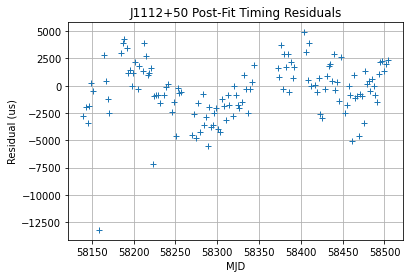

In [295]:
plt.plot(t.get_mjds(), f.resids.time_resids.to(u.us), '+')
plt.title("%s Post-Fit Timing Residuals" % m.PSR.value)
plt.xlabel("MJD")
plt.ylabel("Residual (us)")
plt.grid()

In [296]:
get_mjds_by_residuals(t, f.resids.time_resids, 5000, -6000, u.us)

[58158.930922943866, 58222.75617931188]

In [297]:
limits = ((58150, 58250),(58350, 58450))
total_maks = []
for start, stop in limits:
    mask_toas = []
    copy_toas = copy.copy(t)
    toas_table = copy_toas.table
    for val in table_toas['mjd_float']:
        if start < val < stop:
            mask_toas.append(False)
        else:
            mask_toas.append(True)
    total_maks.append(mask_toas)
    
primary_mask = np.full(copy_toas.ntoas, True)
for item in total_maks:
    primary_mask = primary_mask ^ np.array(item)


In [298]:
primary_mask

array([ True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [299]:
copy_toas.select(primary_mask)

In [300]:
cut_t = exclude_intervals_toas(t, limits)

In [301]:
f = fit.WLSFitter(cut_t, m)
f.fit_toas()

<Quantity 39831.39532348>

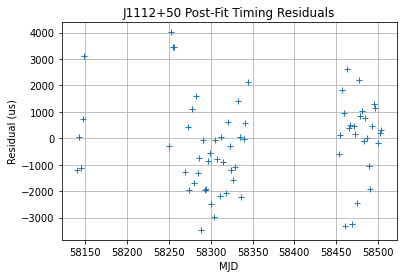

In [302]:
plt.plot(cut_t.get_mjds(), f.resids.time_resids.to(u.us), '+')
plt.title("%s Post-Fit Timing Residuals" % m.PSR.value)
plt.xlabel("MJD")
plt.ylabel("Residual (us)")
plt.grid()